In [1]:
import pandas as pd
import ast
import numpy as np
import re
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

df = pd.read_excel("fr_tfidf.xlsx")

def clean_tfidf(x):
    s = str(x)
    s = s.replace("np.float64", "")
    s = s.replace("float64", "")
    s = s.replace("float32", "")
    s = re.sub(r"defaultdict\([^)]*\),?\s*", "", s)
    s = re.sub(r"\(\s*([0-9.]+)\s*\)", r"\1", s)
    d = ast.literal_eval(s)
    return {k: float(v) for k, v in d.items()}

tfidf_dicts = df["TFIDF"].apply(clean_tfidf)

vec = DictVectorizer(sparse=True)
X = vec.fit_transform(tfidf_dicts)

y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

param_grid = {
    'alpha': [0.01, 0.1, 0.3, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}

grid = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("\n=== BEST PARAMETERS ===")
print(grid.best_params_)

print("\n=== BEST CV SCORE (F1 Weighted) ===")
print(grid.best_score_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== FINAL EVALUATION REPORT ===")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 14 candidates, totalling 70 fits

=== BEST PARAMETERS ===
{'alpha': 0.3, 'fit_prior': True}

=== BEST CV SCORE (F1 Weighted) ===
0.8562053788092967

=== FINAL EVALUATION REPORT ===
              precision    recall  f1-score   support

          CG       0.83      0.88      0.86      4044
          OR       0.88      0.82      0.85      4043

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087



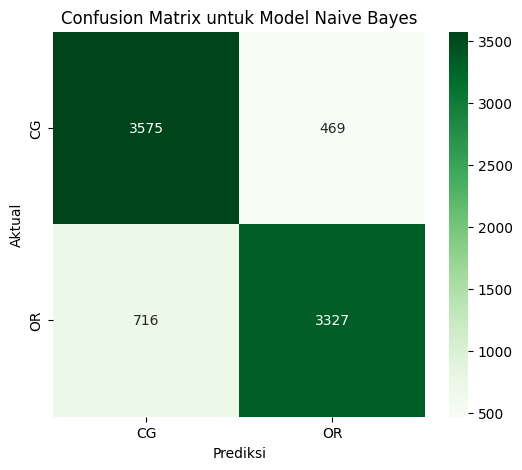

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
labels = ["CG", "OR"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix untuk Model Naive Bayes")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()
